# Dual blocker therapy (DBT) plasma proteome Paper — Figure 5

This Jupyter Notebook (with Python 3 kernel) contained the code for the machine learning construction, model evaluation, and independent validation

Input files:  
* The clinical file: category.csv, continuous.csv, val_clinical.csv, val_coclinical.csv
* The DBT proteome file: dbt.csv
* The validation cohort proteome file: validation.csv

Output figures:  
* Figure 5, Figure S8

In [1]:
from utils import *
paths = ['../figure/figure5', '../documents/figure5']
for path in paths:
    if not os.path.isdir(path):
        os.makedirs(path)

a = Analysis('../')

### Machine learning data preparation

In [2]:
a._data['tmp'] = a.dbt.div(a.dbt.median())
a.set_param('group', dataset_type='dbt', group_name='Response state', file_type='category', thresh=.7, dividend='DNP', ttest_kwargs={})
ml_discovery_data = a.merge_data_group(['PA', 'LDH', 'APOC3'], data_type=['continuous', 'tmp']).rename(columns=lambda x: x.split('|')[0]).reset_index().replace(['DNP', 'DP'], [0, 1]).dropna()
ml_discovery_data.to_csv('../documents/ml/DBT_ml_data.csv', index=False)

features = ml_discovery_data.columns[2:]
X = ml_discovery_data.iloc[:, 2:]
y = ml_discovery_data.iloc[:, 1]

a._data['tmp'] = a.validation.div(a.validation.median())
a.set_param('group', dataset_type='validation', group_name='Response state', file_type='val_clinical', thresh=.7, dividend='DNP')
ml_validation_data = a.merge_data_group(['PA', 'LDH', 'APOC3'], data_type=['val_coclinical', 'tmp']).rename(columns=lambda x: x.split('|')[0]).reset_index().replace(['DNP', 'DP'], [0, 1]).dropna()

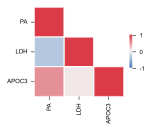

In [3]:
features_corr_df = ml_discovery_data[features].corr(method='spearman')
t = np.zeros((3, 3), int)
np.fill_diagonal(t, 1)
mask = np.triu(np.ones_like(features_corr_df, dtype=bool))
ax = heatmap(features_corr_df, mask=mask - t, square=True, figsize=(2, 2), xticklabels=True, cbar_kws={'shrink': .3, 'aspect': 10}, linewidth=1, linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.get_figure().savefig('../figure/figure5/FigS8A_feature_correlation_heatmap.pdf', bbox_inches='tight')

### Utils for model evaluation

In [4]:
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, f1_score, precision_score, recall_score
from collections import defaultdict

def evaluate_multiple_metrics(model, X, y, return_scores=False):
    out = {}
    scores = {}
    for i in [roc_auc_score, balanced_accuracy_score, f1_score, precision_score, recall_score]:
        name = i.__name__
        predict_X = model.predict(X)
        try:
            predict_X_prob = model.predict_proba(X)[:, 1]
        except:
            predict_X_prob = model.decision_function(X)
        if name == 'roc_auc_score':
            out[name] = i(y, predict_X_prob)
        else:
            out[name] = i(y, predict_X)

        scores['predict'] = predict_X
        scores['predict_prob'] = predict_X_prob
        
    if return_scores:
        return out, scores
    else:
        return out

def rec_dd():
    return defaultdict(rec_dd)


In [8]:
path = '../documents/ml'
feature_combinations = ['APOC3', 'LDH', 'PA', 'LDH+PA', 'LDH+PA+APOC3']

### Final models

In [9]:
final_models = {
    'APOC3': ['robust', 'APOC3_RandomForestClassifier_tuned_model.joblib'],
    'LDH': ['standard', 'LDH_SVC_tuned_model.joblib'],
    'PA': ['robust', 'PA_GaussianProcessClassifier_tuned_model.joblib'],
    'LDH+PA': ['robust', 'LDH+PA_RandomForestClassifier_tuned_model.joblib'],
    'LDH+PA+APOC3': ['normalizer', 'LDH+PA+APOC3_RandomForestClassifier_tuned_model.joblib']
}

### Final models repeating refitting evaluation

In [10]:
import joblib
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn import metrics

re = rec_dd()
scores = {}
fi = {}
for feature_name, v in final_models.items():
    scaler_type, model_path = v
    model = joblib.load(os.path.join(path, 'final_model', model_path))
    for random_state in range(1, 101, 1):
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, stratify=y, random_state=random_state)
        Scaler = {'standard': StandardScaler(), 'minmax': MinMaxScaler(), 'normalizer': Normalizer(), 'robust': RobustScaler()}.get(scaler_type, 'no')
        scaler = Scaler.fit(X_train)
        X_train_ = scaler.transform(X_train)
        X_test_ = scaler.transform(X_test)
        X_ = scaler.transform(X)
        model.fit(X_train_, y_train)

        for cohort_name, X_data, y_data in zip(['train', 'test', 'discovery'], [X_train_, X_test_, X_],[y_train, y_test, y]):
            output_report1, output_scores1 = evaluate_multiple_metrics(model, X_data, y_data, return_scores=True)
            output_report2 = metrics.classification_report(y_data, model.predict(X_data), output_dict=True)

            output_report1_df = pd.DataFrame().from_dict(output_report1, orient='index')[0]
            output_report2_df = pd.DataFrame().from_dict(output_report2).iloc[:-1, 3:].unstack()
            output_report2_df.index = output_report2_df.index.map(lambda x: '-'.join(x))
            output_report_df = pd.concat([output_report1_df, output_report2_df])
            re[cohort_name][feature_name][random_state]['metrics'] = output_report_df
            re[cohort_name][feature_name][random_state]['scores'] = output_scores1
        if feature_name == 'LDH+PA+APOC3':
            fi[random_state] = model.feature_importances_

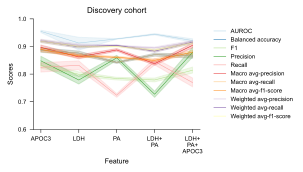

In [11]:
all_df = pd.DataFrame()
for k, v in re.items():
    for k1, v1 in v.items():
        for k2, v2 in v1.items():
            tmp = v2['metrics'].rename('Scores').to_frame().assign(Feature=k1, repeat=k2, cohort=k)
            all_df = pd.concat([all_df, tmp])
all_df.index = all_df.index.map(lambda x:{'roc_auc_score': 'AUROC', 'f1_score': 'F1', 'precision_score': 'Precision', 'recall_score': 'Recall', 'balanced_accuracy_score': 'Balanced accuracy'}.get(x, x).capitalize().replace('Auroc', 'AUROC'))
all_df['Feature'] = all_df['Feature'].str.replace('+', '+\n')
ax = lineplot(all_df.query('cohort=="discovery"').rename_axis('Metrics').reset_index().iloc[:, [-3, 0, 1]], ticklabels_format=[], ticklabels_hide=[], palette=MCMAP[:all_df.index.nunique()], figsize=(3, 2), title='Discovery cohort')
ax.set_yticks([i/10 for i in range(6, 11)])
ax.set_yticklabels([i/10 for i in range(6, 11)])
ax.get_figure().savefig('../figure/figure5/Fig5B_discovery_metrics_comparison_lineplot.pdf', bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


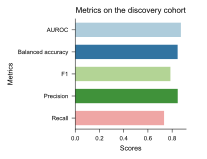

In [12]:
tmp = all_df.query("cohort=='discovery'&repeat==42").loc[['AUROC', 'Balanced accuracy', 'F1', 'Precision', 'Recall']].rename_axis('Metrics').reset_index()
ax = tmp[tmp['Feature']=='LDH+\nPA+\nAPOC3'].iloc[:, [0, 1]].pipe(barplot, orient='h', dodge=True, palette=MCMAP[:5], ticklabels_format=[], ticklabels_hide=[], figsize=(2, 2), title='Metrics on the discovery cohort')
new_value = .65
for patch in ax.patches :
    current_height = patch.get_height()
    diff = current_height - new_value
    patch.set_height(new_value)
    patch.set_y(patch.get_y() + diff * .5)
ax.get_figure().savefig('../figure/figure5/FigS8B_discovery_metrics_barplot.pdf', bbox_inches='tight')

### The feature importance of model with all features (LDH, PA, APOC3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


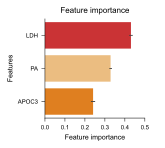

In [13]:
fi_df = pd.DataFrame().from_dict(fi, orient='index', columns=features).iloc[:, [1,0,-1]].rename_axis('Repeat').rename_axis('Features', axis=1)
fi_df.to_csv('../documents/figure5/Integrated_all_features_model_feature_importance.csv')

ax = barplot(fi_df.stack().rename('Feature importance'), orient='h', figsize=(1.8, 1.8), title='Feature importance', ticklabels_hide=[], ticklabels_format=[], palette=MCMAP[5:8])
ax.set_xticks([i/10 for i in range(6)])
ax.set_xticklabels([i/10 for i in range(6)])
ax.get_figure().savefig('../figure/figure5/Fig5C_model_feature_importance_barplot.pdf', bbox_inches='tight')

### Confusion matrix of the models on the independent validation cohort

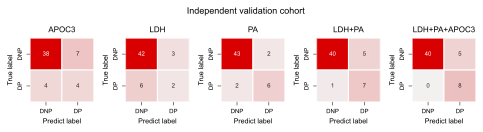

In [14]:
fig, axs = plt.subplots(1, 5, figsize=(8, 1.8))
plt.subplots_adjust(wspace=.5)

for feature_combination, ax in zip(feature_combinations, axs):
    model = joblib.load(os.path.join(path, 'final_model', final_models[feature_combination][1]))
    features = feature_combination.split('+')

    X_train, X_test, y_train, y_test = train_test_split(X[features], y, train_size=.7, stratify=y, random_state=42)
    X_valid = ml_validation_data[features]
    y_valid = ml_validation_data.iloc[:, 1]
    
    Scaler = {'standard': StandardScaler(), 'minmax': MinMaxScaler(), 'normalizer': Normalizer(), 'robust': RobustScaler()}.get(final_models[feature_combination][0])

    scaler = Scaler.fit(X_train)
    X_train_ = scaler.transform(X_train)
    X_test_ = scaler.transform(X_test)
    X_valid_ = scaler.transform(X_valid)
    model.fit(X_train_, y_train)

    cm = metrics.confusion_matrix(y_valid, model.predict(X_valid_))
    cm = pd.DataFrame(cm, index=['DNP', 'DP'], columns=['DNP', 'DP'])
    heatmap(cm, vmax=None, vmin=0, center=None, ax=ax, cbar=False, square=True, cmap=R_CMAP, annot=True, linewidth=1, linecolor='white', xticklabels=True)
    ax.set_xlabel('Predict label')
    ax.set_ylabel('True label')
    ax.set_title(feature_combination, fontsize=8)
plt.suptitle('Independent validation cohort', fontsize=9)
fig.savefig('../figure/figure5/Fig5D-FigS8C_models_validation_confusion_matrix_heatmap.pdf', bbox_inches='tight')

### Evaluated model performance on the validation cohort by multiple metrics

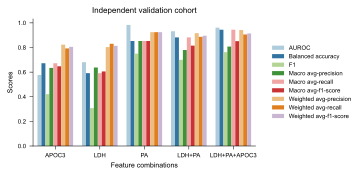

In [19]:
from sklearn import metrics

all_output_report_df = pd.DataFrame()
for feature_combination, ax in zip(feature_combinations, axs):
    model = joblib.load(os.path.join(path, 'final_model', final_models[feature_combination][1]))
    features = feature_combination.split('+')
    X_train, X_test, y_train, y_test = train_test_split(X.loc[:, features], y, train_size=.7, stratify=y, random_state=42)
    X_valid = ml_validation_data[features]
    y_valid = ml_validation_data.iloc[:, 1]
    
    Scaler = {'standard': StandardScaler(), 'minmax': MinMaxScaler(), 'normalizer': Normalizer(), 'robust': RobustScaler()}.get(final_models[feature_combination][0], 'no')

    scaler = Scaler.fit(X_train)
    X_train_ = scaler.transform(X_train)
    X_test_ = scaler.transform(X_test)
    X_valid_ = scaler.transform(X_valid)
    model.fit(X_train_, y_train)

    validation_output_report1 = evaluate_multiple_metrics(model, X_valid_, y_valid)
    validation_output_report2 = metrics.classification_report(y_valid, model.predict(X_valid_), output_dict=True)

    output_report1_df = pd.DataFrame().from_dict(validation_output_report1, orient='index')[0]
    output_report2_df = pd.DataFrame().from_dict(validation_output_report2).iloc[:-1, 3:].unstack()
    output_report2_df.index = output_report2_df.index.map(lambda x: '-'.join(x))
    output_report_df = pd.concat([output_report1_df, output_report2_df])
    output_report_df.index = output_report_df.index.map(lambda x:{'roc_auc_score': 'AUROC', 'f1_score': 'F1', 'precision_score': 'Precision', 'recall_score': 'Recall', 'balanced_accuracy_score': 'Balanced accuracy'}.get(x, x).capitalize().replace('Auroc', 'AUROC'))
    all_output_report_df = pd.concat([all_output_report_df, output_report_df.rename('Scores').to_frame().assign(annot=feature_combination)]).drop(['Precision', 'Recall'])
all_output_report_df.to_csv('../documents/figure5/Models_performance_independent-validation-cohort.csv')
ax = barplot(all_output_report_df.reset_index().iloc[:, [-1, 0, 1]], dodge=True, palette=MCMAP[:9], ticklabels_format=[], ticklabels_hide=[], figsize=(4, 2.3), title='Independent validation cohort')
ax.set_xlabel('Feature combinations')
ax.get_figure().savefig('../figure/figure5/Fig5E_validation_metrics_barplot.pdf', bbox_inches='tight')

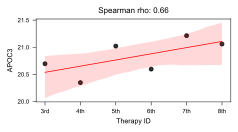

In [18]:
a.val_clinical['Patient ID'].value_counts()
a.set_param('group', dataset_type='validation', group_name='Patient ID', part_element=['P12'], file_type='val_clinical')
df = a.merge_data_group(['APOC3'], group_name=['Patient ID', 'Therapy ID']).reset_index('Therapy ID')
df['Therapy ID'] = df['Therapy ID'].str[:1].astype(int)

rho, _ = scipy.stats.spearmanr(df['Therapy ID'], df['APOC3'])
scatter_kws = {'s': 15, 'color': 'black'}
line_kws = {'color': 'red'}

fig, ax = plt.subplots(1, 1, figsize=(3.5, 1.5))
sns.regplot(data=df.iloc[:, [1, 0]], x='Therapy ID', y='APOC3', ax=ax, line_kws=line_kws, scatter_kws=scatter_kws)
ax.set_title('Spearman rho: {:.2f}'.format(rho))
ax.set_xticks(range(3, 9, 1))
ax.set_xticklabels(['3rd', '4th', '5th', '6th', '7th', '8th'])
ax.get_figure().savefig('../figure/figure5/FigS8D_validation_APOC3_Therapy-ID_regplot.pdf', bbox_inches='tight')